# Before you get started

## Data formatting

Ensure that your expression data is of the form log2(TPM+1) or log2(FPKM+1)

miner will search for specific filenames in the miner/data folder. In order to avoid "File does not exist" errors, do the following:
    1. Name your expression data "expressionData.csv"
    2. Name your mutation data "mutations.csv" (only for causal analysis)
    3. Name your survival data "survival.csv" (only for survival analysis)
   
Note that the gene names will be converted to Ensembl Gene ID format

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [48]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.metrics import f1_score
import miner
%matplotlib inline

## Create directory to save output files

In [49]:
# create name for results folder where output files will be saved
resultsFolder = "results"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load input data

In [51]:
# read gene expression into pandas dataframe
expressionData = pd.read_csv(os.path.join("..","data","IA12Zscore.csv"),index_col=0,header=0)
# convert gene names to Ensembl Gene ID
expressionData = miner.identifierConversion(expressionData)
# pre-process expressionData for optimized performance
expressionData = miner.zscore(expressionData)

completed identifier conversion.
16216 genes were converted.


## Load previous results

In [54]:
# If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulons = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))

## 1. Cluster expression data

In [279]:
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes=8,overExpressionThreshold=80)
# sort cluster list from largest to smallest
initialClusters.sort(key= lambda s: -len(s))
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

0.00 percent complete
6.67 percent complete
13.33 percent complete
20.00 percent complete
26.67 percent complete
807 genes have been clustered.
33.33 percent complete
40.00 percent complete
46.67 percent complete
53.33 percent complete
60.00 percent complete
930 genes have been clustered.
66.67 percent complete
73.33 percent complete
80.00 percent complete
86.67 percent complete
93.33 percent complete
970 genes have been clustered.

coexpression clustering completed in 1.05 minutes


## Infer bicluster membership of revised clusters

In [10]:
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label=2)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label=0)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label="included")

done!
done!
done!
done!


## Generate bicluster membership incidence matrices

In [11]:
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
#dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
#coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

## Generate matrix of bicluster medians

In [12]:
clusterMedianMatrix = miner.coexpressionMedianMatrix(expressionData,revisedClusters)
clusterMedianMatrix.head(5)

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
0,-0.041464,-0.055721,0.121174,0.760636,-0.594060,-0.110728,0.810365,-0.304036,0.649922,-0.244382,...,-0.121344,0.352858,-0.498699,0.466413,0.132372,0.340504,-0.105608,-0.064952,-0.646715,-0.295995
2,-0.117223,0.039179,0.007602,0.454621,-0.494439,0.240869,0.921061,-0.296383,0.744268,-0.167133,...,0.116662,0.254924,-0.435335,0.619947,-0.061317,0.256550,-0.014221,-0.075881,-0.654871,-0.122625
3,0.009110,0.214291,-0.000890,0.344347,-0.331443,0.472050,1.149611,-0.194085,1.137009,-0.139063,...,0.258660,0.040357,-0.283710,0.734291,-0.134484,0.247418,-0.054632,-0.074138,-0.591579,-0.108381
4,0.124690,0.147627,-0.212593,0.778628,-0.411470,-0.111200,0.560291,-0.198214,0.491816,-0.391661,...,0.050600,0.228166,-0.365855,0.161935,-0.049786,0.416669,0.431557,-0.020636,-0.285723,-0.146824
5,0.627351,0.245601,-0.331488,0.393913,0.091739,0.146664,-0.209630,0.083342,-0.159558,-0.049952,...,0.248423,-0.385055,0.284802,-0.238257,-0.132409,0.542515,0.647939,-0.075709,0.083657,0.276180


## 2. Infer coregulated modules

In [233]:
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=5,freqThreshold = 0.333)
# write regulons to json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))


miner.py:901: RuntimeWarning: invalid value encountered in greater_equal
  


0
156
157
312
313
468
314
158
159
625
315
469
470
626
160
316
317
471
472
627
318
628
629
630
161
473
319
631
632
633
162
474
320
475
634
476
321
163
635
636
477
322
637
164
478
638
323
639
479
640
480
481
324
165
641
482
483
642
325
166
484
485
643
326
644
486
167
327
487
645
646
328
168
488
647
329
330
648
169
489
170
331
490
649
491
332
171
650
333
492
493
334
651
172
652
494
335
336
173
174
653
495
175
176
654
337
655
177
496
497
178
338
179
656
180
498
657
181
339
658
499
659
340
182
183
500
184
501
502
503
504
660
661
341
662
663
185
186
505
664
342
187
665
506
343
666
667
188
507
508
344
509
668
345
189
510
669
190
511
346
670
512
347
191
671
513
672
348
192
673
514
193
194
674
349
675
350
515
195
676
196
677
678
679
516
351
197
198
680
517
518
352
519
520
681
682
199
353
521
522
683
200
354
355
523
684
524
685
201
525
686
356
687
688
202
526
357
689
527
203
204
205
690
358
691
528
206
692
359
693
529
694
360
207
530
695
696
361
697
208
531
209
532
362
698
533
210
699
363
534
21

## Infer bicluster membership of coexpression modules

In [55]:
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label=2)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label=0)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label="included")

done!
done!
done!
done!


## Generate bicluster membership incidence matrices

In [56]:
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
#dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
#coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

In [57]:
coexpressionMatrix = miner.coexpressionMedianMatrix(expressionData,coexpressionModules)
coexpressionMatrix.head(5)

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
0,-0.033608,-0.039469,0.124968,0.770567,-0.597342,-0.110728,0.824197,-0.306955,0.654906,-0.244382,...,-0.126641,0.353571,-0.498699,0.459818,0.140895,0.349416,-0.105608,-0.062208,-0.645272,-0.298523
1,-0.067038,0.049441,-0.119256,0.244873,-0.337051,0.217096,0.626614,-0.234527,0.566974,-0.203591,...,0.142384,0.001749,-0.353925,0.448444,-0.235522,0.126490,-0.091635,-0.142103,-0.545210,-0.180311
2,0.140031,0.149388,-0.173100,0.798535,-0.403821,-0.111200,0.574363,-0.182659,0.498020,-0.386454,...,0.050600,0.224638,-0.381209,0.172700,-0.059186,0.416669,0.431557,0.003665,-0.284061,-0.150591
3,0.617807,0.375871,-0.339693,0.414243,0.118394,0.143428,-0.132089,0.088349,-0.229228,-0.049952,...,0.248423,-0.428306,0.257967,-0.243980,-0.125285,0.569227,0.676764,-0.027828,0.086502,0.366713
4,-0.145702,0.838217,-0.713724,0.350953,0.199303,0.516291,0.274542,0.112285,-0.091985,0.134493,...,0.802754,-0.356757,0.296382,0.600866,-0.668572,0.508105,0.418652,-0.493247,0.024335,0.453072


## Predict sample classes

In [58]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix

In [59]:
similarityClusters = miner.getSimilarityClusters(sampleDictionary,fequencyThreshold=0.333,similarityThreshold=0.15,highResolution=False)
highResolutionClusters, unclustered = miner.getSimilarityClusters(sampleDictionary,fequencyThreshold=0.333,similarityThreshold=0.15,highResolution=True)

done!
done!
done!
done!
done!
done!
done!
done!
done!


In [60]:
initialClasses = miner.classesFromClusters(highResolutionClusters)

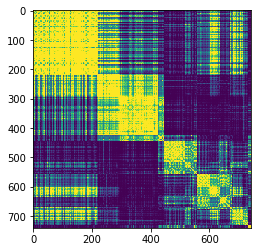

In [61]:
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True)
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
plt.imshow(similarityMatrix.loc[np.hstack(initialClasses),np.hstack(initialClasses)],vmax=0.5)
#plt.savefig(os.path.join(resultsDirectory,"patientClasses15percent.pdf"))

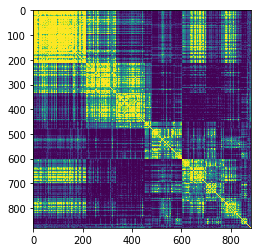

In [62]:
centroidClusters, centroidMatrix = miner.centroids(initialClasses,sampleMatrix,f1Threshold = 0.3,returnCentroids=True)
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
plt.imshow(similarityMatrix.loc[mappedSamples,mappedSamples],vmin=0,vmax=0.55)

In [63]:
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.25)

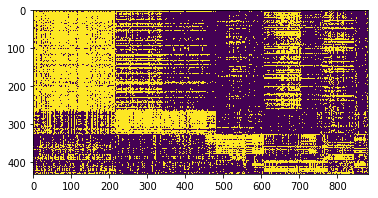

In [64]:
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,resultsDirectory=resultsDirectory)

In [47]:
orderedOverExpressedMembers

NameError: name 'orderedOverExpressedMembers' is not defined

## Analyze sample classes

In [ ]:
reload(miner)
startTimer = time.time()
laplacian, eigenvectors, eigenvalues = miner.laplacian(regulons)
stopTimer = time.time()
print('completed topological analysis in {:.2f} minutes'.format((stopTimer-startTimer)/60.))

In [34]:
transformedExpressionData = miner.transformBiclusters(expressionData.loc[laplacian.index,:],override=eigenvectors)

ValueError: shapes (12722,30) and (881,12722) not aligned: 30 (dim 1) != 881 (dim 0)

In [37]:
np.matmul(np.array(eigenvectors.T),np.array(expressionData.loc[laplacian.index,:]))

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [45]:
overlapIndex = list(set(laplacian.index)&set(expressionData.index))
trnsfrmd = np.matmul(np.array(eigenvectors.loc[overlapIndex,:].T),np.array(expressionData.loc[overlapIndex,:]))

In [46]:
trnsfrmd.shape

(30, 881)

In [75]:
def expandRegulonDictionary(regulons):
    regulonDictionary = {}
    for tf in regulons.keys():
        for key in regulons[tf].keys():
            regulonKey = ("_").join([tf,key])
            regulonDictionary[regulonKey] = regulons[tf][key]
    return regulonDictionary


In [78]:
reload(miner)
regulonDictionary = miner.expandRegulonDictionary(regulons)
regulonDictionary.keys()[0:10]

[u'ENSG00000230257_8',
 u'ENSG00000230257_9',
 u'ENSG00000230257_2',
 u'ENSG00000230257_3',
 u'ENSG00000230257_0',
 u'ENSG00000230257_1',
 u'ENSG00000230257_6',
 u'ENSG00000230257_7',
 u'ENSG00000230257_4',
 u'ENSG00000230257_5']

## Regulon stratification

In [79]:
regulonDictionary = miner.expandRegulonDictionary(regulons)

In [80]:
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(regulonDictionary,bkgd,label=2)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(regulonDictionary,bkgd,label=0)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(regulonDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(regulonDictionary,bkgd,label="included")

done!
done!
done!
done!


In [82]:
reload(miner)
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
#dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
#coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

In [83]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix

In [84]:
similarityClusters = miner.getSimilarityClusters(sampleDictionary,fequencyThreshold=0.333,similarityThreshold=0.15,highResolution=False)
highResolutionClusters, unclustered = miner.getSimilarityClusters(sampleDictionary,fequencyThreshold=0.333,similarityThreshold=0.15,highResolution=True)

done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!


In [85]:
initialClasses = miner.classesFromClusters(highResolutionClusters)

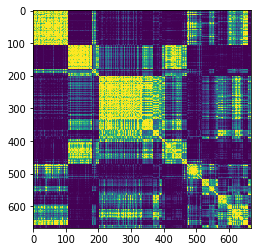

In [86]:
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True)
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
plt.imshow(similarityMatrix.loc[np.hstack(initialClasses),np.hstack(initialClasses)],vmax=0.5)
#plt.savefig(os.path.join(resultsDirectory,"patientClasses15percent.pdf"))

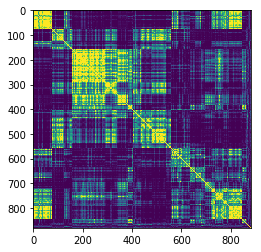

In [87]:
centroidClusters, centroidMatrix = miner.centroids(initialClasses,sampleMatrix,f1Threshold = 0.3,returnCentroids=True)
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
plt.imshow(similarityMatrix.loc[mappedSamples,mappedSamples],vmin=0,vmax=0.55)

In [88]:
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.25)

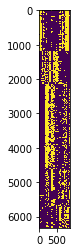

In [89]:
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,resultsDirectory=resultsDirectory)

In [93]:
orderedOverExpressedMembers.head(5)

,MMRF_2539_1_BM,MMRF_2055_1_BM,MMRF_2413_1_BM,MMRF_2080_1_BM,MMRF_2677_1_BM,MMRF_1944_1_BM,MMRF_2795_1_BM,MMRF_1485_1_BM,MMRF_2820_1_BM,MMRF_2675_1_BM,...,MMRF_1523_1_BM,MMRF_1332_1_BM,MMRF_1439_1_BM,MMRF_1157_2_BM,MMRF_1157_3_BM,MMRF_1078_1_BM,MMRF_2229_1_BM,MMRF_1380_2_BM,MMRF_1846_1_BM,MMRF_1618_1_BM
ENSG00000230257_8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000230257_9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000230257_3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000230257_0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000107175_11,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Cox survival based upon binary regulon membership

In [100]:
membershipSurvival = miner.parallelMemberSurvivalAnalysis(membershipDf = orderedOverExpressedMembers,numCores=5,survivalPath=os.path.join("..","data","survivalIA12.csv"),survivalData=None)

10
10
10
10
10
20
20
20
20
20
30
30
30
30
40
30
40
40
50
40
40
50
50
60
50
50
60
60
70
60
70
80
60
70
90
80
70
80
70
100
90
90
80
80
110
100
100
90
90
120
110
110
100
100
130
120
120
140
110
110
130
130
150
120
120
140
140
160
130
130
150
170
150
180
140
160
140
160
190
170
150
150
170
200
180
180
160
160
210
190
190
170
170
220
200
200
230
180
180
210
210
240
220
190
190
250
220
230
200
200
260
230
240
210
270
210
240
250
280
220
220
250
260
290
230
260
270
230
300
270
240
280
240
310
290
280
250
250
320
300
290
330
260
260
310
300
340
270
270
320
350
310
280
280
330
360
320
290
340
290
370
330
380
350
300
300
340
360
390
310
350
310
400
370
320
360
320
410
380
370
330
330
420
390
380
430
340
400
340
390
440
410
350
350
450
400
420
360
360
460
410
430
370
470
370
440
420
480
380
380
450
430
490
390
460
390
440
500
470
400
400
510
450
480
520
460
410
410
490
530
470
420
420
500
540
480
430
430
510
550
490
440
520
440
560
500
530
450
570
450
510
540
580
460
460
550
520
590
470
470
560
5

In [103]:
stratifiers = miner.getStratifiers(membershipSurvival,threshold = 1e-16)

In [104]:
stratifiers

{u'ENSG00000068323_14': (8.633173122071158, 5.967301505573233e-18),
 u'ENSG00000101057_5': (8.452991258782221, 2.839329419477585e-17),
 u'ENSG00000105967_10': (8.550054837502936, 1.2303004496077138e-17),
 u'ENSG00000106689_1': (8.74813661619681, 2.1690457448434988e-18),
 u'ENSG00000122877_4': (8.651506671969136, 5.082392007029014e-18),
 u'ENSG00000123095_11': (8.739997264150823, 2.3311607278101122e-18),
 u'ENSG00000125952_7': (8.488940150260763, 2.0853007445912954e-17),
 u'ENSG00000126351_14': (9.28901818060162, 1.5571806466647514e-20),
 u'ENSG00000129173_11': (8.39202252278204, 4.778493312067193e-17),
 u'ENSG00000132170_18': (8.565278873267614, 1.0781458405916155e-17),
 u'ENSG00000156273_15': (8.661252872957913, 4.6660716293342e-18),
 u'ENSG00000169926_10': (8.780857372847361, 1.6223316963931757e-18),
 u'ENSG00000174282_5': (8.319135806814504, 8.860697755617831e-17),
 u'ENSG00000180806_9': (8.518288436904891, 1.6192851004638013e-17),
 u'ENSG00000186827_15': (8.391921977136093, 4.78258

In [105]:
regulonDictionary['ENSG00000126351_14']

[u'ENSG00000181938',
 u'ENSG00000143155',
 u'ENSG00000122376',
 u'ENSG00000111726',
 u'ENSG00000051180',
 u'ENSG00000111206',
 u'ENSG00000171792',
 u'ENSG00000147099',
 u'ENSG00000167895',
 u'ENSG00000183520',
 u'ENSG00000204859',
 u'ENSG00000141524',
 u'ENSG00000108468',
 u'ENSG00000145331',
 u'ENSG00000181610',
 u'ENSG00000023228',
 u'ENSG00000171960',
 u'ENSG00000112759',
 u'ENSG00000106351',
 u'ENSG00000123416',
 u'ENSG00000173207',
 u'ENSG00000135778',
 u'ENSG00000160991',
 u'ENSG00000155561',
 u'ENSG00000138660',
 u'ENSG00000160752',
 u'ENSG00000136783',
 u'ENSG00000140905',
 u'ENSG00000139350',
 u'ENSG00000101773',
 u'ENSG00000115539',
 u'ENSG00000101189',
 u'ENSG00000058804',
 u'ENSG00000170779',
 u'ENSG00000022277',
 u'ENSG00000123297',
 u'ENSG00000103495',
 u'ENSG00000161692',
 u'ENSG00000171320',
 u'ENSG00000156876',
 u'ENSG00000227268',
 u'ENSG00000155111',
 u'ENSG00000104299',
 u'ENSG00000154582',
 u'ENSG00000107937',
 u'ENSG00000092841',
 u'ENSG00000179750',
 u'ENSG000001

In [156]:
symbols = miner.gene_conversion(regulonDictionary['ENSG00000106689_1'],list_symbols=True)

querying 1-123...done.
Finished.


In [157]:
np.savetxt(os.path.join(resultsDirectory,"regulonStratifier.txt"),regulonDictionary['ENSG00000106689_1'],fmt="%1.50s")

In [158]:
stratifierGeneset = pd.read_table(os.path.join(resultsDirectory,"regulonStratifier.txt"),header=None)
stratifierGeneset = list(set(list(stratifierGeneset[0]))&set(expressionData.index))

# Validation datasets

In [ ]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)
print(list(set(survival.index)))

## GSE24080UAMS

In [ ]:
survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalGSE24080UAMS.head(3)
survivalDf = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]

In [137]:
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)

In [149]:
# create a background matrix used for statistical hypothesis testing
bkgdUAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembersUAMS = miner.biclusterMembershipDictionary(regulonDictionary,bkgdUAMS,label=2)

done!


In [150]:
reload(miner)
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembersUAMS,expressionDataGSE24080UAMS)

{'ENSG00000126351_14': (3.63305647114859, 0.00028008368966399484)}

In [153]:
membershipSurvivalUAMS = miner.parallelMemberSurvivalAnalysis(membershipDf = pd.DataFrame(overExpressedMembersMatrix.loc[stratifiers.keys(),:]),numCores=5,survivalPath="",survivalData=survivalDf)

In [155]:
stratifiers['ENSG00000106689_1']

(8.74813661619681, 2.1690457448434988e-18)

## GSE19784HOVON65

In [170]:
survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalGSE19784HOVON65.head(3)
survivalDf = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]

In [162]:
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65 = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)

completed identifier conversion.
16998 genes were converted.
completed z-transformation.


In [163]:
# create a background matrix used for statistical hypothesis testing
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonDictionary,bkgdGSE19784HOVON65,label=2)

done!


In [164]:
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

In [171]:
membershipSurvivalGSE19784HOVON65 = miner.parallelMemberSurvivalAnalysis(membershipDf = pd.DataFrame(overExpressedMembersMatrixGSE19784HOVON65.loc[stratifiers.keys(),:]),numCores=5,survivalPath="",survivalData=survivalDf)

## EMTAB4032

In [173]:
survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalEMTAB4032.head(3)
survivalDf = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]

In [175]:
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032 = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)

completed identifier conversion.
17228 genes were converted.
completed z-transformation.


In [176]:
# create a background matrix used for statistical hypothesis testing
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonDictionary,bkgdEMTAB4032,label=2)

done!


In [177]:
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)

In [178]:
membershipSurvivalEMTAB4032 = miner.parallelMemberSurvivalAnalysis(membershipDf = pd.DataFrame(overExpressedMembersMatrixEMTAB4032.loc[stratifiers.keys(),:]),numCores=5,survivalPath="",survivalData=survivalDf)

/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000156273_15'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000106689_1'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_t

In [179]:
membershipSurvivalEMTAB4032

{u'ENSG00000068323_14': (1.0464023054066973, 0.2953753288112754),
 u'ENSG00000101057_5': (1.0281641294577553, 0.30387262859235825),
 u'ENSG00000105967_10': (1.6123116889894358, 0.10689413097313664),
 u'ENSG00000106689_1': (2.87669797225159, 0.004018600276241224),
 u'ENSG00000122877_4': (1.6823273777178536, 0.09250537508238163),
 u'ENSG00000123095_11': (1.4993066838151758, 0.13379408923248792),
 u'ENSG00000125952_7': (1.623653539300272, 0.10444977202226619),
 u'ENSG00000126351_14': (1.1591041680037708, 0.24641372715395676),
 u'ENSG00000129173_11': (1.8712006978799403, 0.0613172680865289),
 u'ENSG00000132170_18': (1.3698301284564722, 0.1707399348120779),
 u'ENSG00000156273_15': (2.532815248483925, 0.011315057311127268),
 u'ENSG00000169926_10': (1.0712984983695182, 0.2840352348061744),
 u'ENSG00000174282_5': (0.7745518477916687, 0.43860451993606275),
 u'ENSG00000180806_9': (1.8868719298824097, 0.0591775534250723),
 u'ENSG00000186827_15': (3.008874542376096, 0.0026221737150175835),
 u'ENSG

# Validation results

In [183]:
membershipSurvivalUAMS

{u'ENSG00000068323_14': (4.156424218506632, 3.232673310577571e-05),
 u'ENSG00000101057_5': (3.4824753817130634, 0.0004968008976904367),
 u'ENSG00000105967_10': (4.363477563501698, 1.2801107495422208e-05),
 u'ENSG00000106689_1': (6.580312713220875, 4.694598392480378e-11),
 u'ENSG00000122877_4': (2.525150826021904, 0.011564864329643017),
 u'ENSG00000123095_11': (3.9376388177384976, 8.228732877337138e-05),
 u'ENSG00000125952_7': (6.2110728617706465, 5.262406431094171e-10),
 u'ENSG00000126351_14': (3.63305647114859, 0.00028008368966399484),
 u'ENSG00000129173_11': (4.724697705124355, 2.304579135611782e-06),
 u'ENSG00000132170_18': (4.603430347737963, 4.155882285464082e-06),
 u'ENSG00000156273_15': (5.582087536555614, 2.3764870611568696e-08),
 u'ENSG00000169926_10': (4.297296394206347, 1.728939454688792e-05),
 u'ENSG00000174282_5': (4.302438634978358, 1.6892846550127863e-05),
 u'ENSG00000180806_9': (4.3047139081666055, 1.6720166795466876e-05),
 u'ENSG00000186827_15': (6.1927972414149455, 5.

In [184]:
membershipSurvivalGSE19784HOVON65

{u'ENSG00000068323_14': (1.4944814229102295, 0.13504983389648728),
 u'ENSG00000101057_5': (1.5568142510218583, 0.11951459269591207),
 u'ENSG00000105967_10': (4.44007074205567, 8.992931155949848e-06),
 u'ENSG00000106689_1': (5.249849088043724, 1.5222386683135608e-07),
 u'ENSG00000122877_4': (4.033290887308326, 5.500112574935235e-05),
 u'ENSG00000123095_11': (3.2613236622697794, 0.0011089338220060434),
 u'ENSG00000125952_7': (4.607877430201558, 4.068003340419648e-06),
 u'ENSG00000126351_14': (2.1040907050580073, 0.03537053550221604),
 u'ENSG00000129173_11': (2.5261417389327065, 0.01153229435158259),
 u'ENSG00000132170_18': (2.7970291398376967, 0.005157488147511143),
 u'ENSG00000156273_15': (3.655090675331407, 0.0002570910951067108),
 u'ENSG00000169926_10': (4.439013073392632, 9.037232765689297e-06),
 u'ENSG00000174282_5': (3.8088077851509654, 0.00013963845278865976),
 u'ENSG00000180806_9': (3.3291355528066546, 0.0008711599396373588),
 u'ENSG00000186827_15': (3.1789409338985166, 0.0014781

In [185]:
membershipSurvivalEMTAB4032

{u'ENSG00000068323_14': (1.0464023054066973, 0.2953753288112754),
 u'ENSG00000101057_5': (1.0281641294577553, 0.30387262859235825),
 u'ENSG00000105967_10': (1.6123116889894358, 0.10689413097313664),
 u'ENSG00000106689_1': (2.87669797225159, 0.004018600276241224),
 u'ENSG00000122877_4': (1.6823273777178536, 0.09250537508238163),
 u'ENSG00000123095_11': (1.4993066838151758, 0.13379408923248792),
 u'ENSG00000125952_7': (1.623653539300272, 0.10444977202226619),
 u'ENSG00000126351_14': (1.1591041680037708, 0.24641372715395676),
 u'ENSG00000129173_11': (1.8712006978799403, 0.0613172680865289),
 u'ENSG00000132170_18': (1.3698301284564722, 0.1707399348120779),
 u'ENSG00000156273_15': (2.532815248483925, 0.011315057311127268),
 u'ENSG00000169926_10': (1.0712984983695182, 0.2840352348061744),
 u'ENSG00000174282_5': (0.7745518477916687, 0.43860451993606275),
 u'ENSG00000180806_9': (1.8868719298824097, 0.0591775534250723),
 u'ENSG00000186827_15': (3.008874542376096, 0.0026221737150175835),
 u'ENSG

In [187]:
# reference training set results
stratifiers

{u'ENSG00000068323_14': (8.633173122071158, 5.967301505573233e-18),
 u'ENSG00000101057_5': (8.452991258782221, 2.839329419477585e-17),
 u'ENSG00000105967_10': (8.550054837502936, 1.2303004496077138e-17),
 u'ENSG00000106689_1': (8.74813661619681, 2.1690457448434988e-18),
 u'ENSG00000122877_4': (8.651506671969136, 5.082392007029014e-18),
 u'ENSG00000123095_11': (8.739997264150823, 2.3311607278101122e-18),
 u'ENSG00000125952_7': (8.488940150260763, 2.0853007445912954e-17),
 u'ENSG00000126351_14': (9.28901818060162, 1.5571806466647514e-20),
 u'ENSG00000129173_11': (8.39202252278204, 4.778493312067193e-17),
 u'ENSG00000132170_18': (8.565278873267614, 1.0781458405916155e-17),
 u'ENSG00000156273_15': (8.661252872957913, 4.6660716293342e-18),
 u'ENSG00000169926_10': (8.780857372847361, 1.6223316963931757e-18),
 u'ENSG00000174282_5': (8.319135806814504, 8.860697755617831e-17),
 u'ENSG00000180806_9': (8.518288436904891, 1.6192851004638013e-17),
 u'ENSG00000186827_15': (8.391921977136093, 4.78258

In [ ]:
# results(u'ENSG00000106689_1): 
#(8.74813661619681, 2.1690457448434988e-18);
#(6.580312713220875, 4.694598392480378e-11);
#(5.249849088043724, 1.5222386683135608e-07);
#(2.87669797225159, 0.004018600276241224)

In [188]:
print(expressionData.shape[1], expressionDataGSE24080UAMS.shape[1], expressionDataGSE19784HOVON65.shape[1], expressionDataEMTAB4032.shape[1])

(881, 559, 282, 147)


# Subtype analysis

In [191]:
survivalMMRF = pd.read_csv(os.path.join(resultsDirectory,"..",),index_col=0,header=0)
membershipSurvivalCentroid4 = miner.survivalMembershipAnalysisDirect(membershipDf = pd.DataFrame(orderedOverExpressedMembers.loc[:,centroidClusters[4]]),survivalDf=)

/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000166211_1'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000230257_9'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_te

ValueError: delta contains nan value(s). Convergence halted.

/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Column(s) [u'ENSG00000269404_5'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000269404_5'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000138795_20'] have very l

10
10
10


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Column(s) [u'ENSG00000115507_4'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000115507_4'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


20
20
30
30
40


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000196482_12'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


40


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000102145_12'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


50
50
60
60
70
70
80
80
90
90
100


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000162367_6'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


100
110
110
120
120
130
130
140
140
150
150
160


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000111206_2'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


160
170
170
180
180
190
190
200
200
210
210
220
220
230
230
240
240


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000178951_3'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


250
250
260
260
270
270
280
280
290
290


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000196482_23'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


300
300
310
310
320
320
330
330
340
340


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000129173_6'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


350
350
360
360
370
370
380
380
390
390
400


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000186564_2'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


400
410
410
420
420
430
430
440


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000176887_5'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


440
450
450
460
460
470
470
480
480
490
490
500
500
510
510
520
520
530
530
540
540


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000135363_10'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


550
550
560
560
570
570
580
580


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Column(s) [u'ENSG00000245848_7'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [u'ENSG00000245848_7'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


590
600
610
620
630
640


In [193]:
pd.DataFrame(orderedOverExpressedMembers.loc[:,centroidClusters[4]])

,MMRF_1936_1_BM,MMRF_2328_1_BM,MMRF_1506_1_BM,MMRF_1518_3_BM,MMRF_2091_1_BM,MMRF_1433_4_BM,MMRF_1167_1_BM,MMRF_1450_1_BM,MMRF_2373_2_BM,MMRF_2231_1_BM,...,MMRF_1031_1_BM,MMRF_1189_1_BM,MMRF_1656_1_BM,MMRF_1432_1_BM,MMRF_1453_1_BM,MMRF_1889_3_BM,MMRF_2531_1_BM,MMRF_1876_1_BM,MMRF_1579_1_BM,MMRF_1079_1_BM
ENSG00000230257_8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000230257_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000230257_3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000230257_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000107175_11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
ENSG00000230257_5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000162367_17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000177426_1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000162367_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000132005_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
lens

[76,
 49,
 23,
 11,
 131,
 48,
 47,
 18,
 35,
 41,
 58,
 19,
 52,
 25,
 21,
 23,
 18,
 24,
 15,
 33,
 24,
 52,
 18,
 20]